In [57]:
import pandas as pd
import numpy as np
import matplotlib as plt

In [85]:
pip install eli5

In [58]:
df = pd.read_csv(r'C:\Users\james\AppData\Local\Temp\Temp1_199387_1319582_bundle_archive.zip\US_Accidents_June20.csv')

#Smaller sample
df = df.sample(n=100000, random_state=42)

In [59]:
unique_cats = df.select_dtypes('object').nunique()
unique_cats

ID                       100000
Source                        3
Description               87545
Street                    28209
Side                          2
City                       5743
County                     1169
State                        48
Zipcode                   33202
Country                       1
Timezone                      4
Airport_Code               1531
Weather_Timestamp         72356
Wind_Direction               24
Weather_Condition            77
Sunrise_Sunset                2
Civil_Twilight                2
Nautical_Twilight             2
Astronomical_Twilight         2
Weekday                       7
dtype: int64

In [60]:
#High cardinality categories
high_card = [col for col in unique_cats.index if unique_cats[col]>127]
high_card

['ID',
 'Description',
 'Street',
 'City',
 'County',
 'Zipcode',
 'Airport_Code',
 'Weather_Timestamp']

In [62]:
def wrangle(X):
    X = X.copy()
    #Drop high cardinality columns
    X.drop(high_card, axis=1, inplace=True)
    
    #Drop more columns- country and turning loop only have 1 unique value
    X.drop(['Turning_Loop', 'Country'], axis=1, inplace=True)
    
    #Drop columns with high percentage of NaNs
    X.drop(['End_Lat', 'End_Lng', 'Number', 'Wind_Chill(F)', 'Precipitation(in)'],axis=1, inplace=True)
    
    #Putting Times in datetime format
    df['Start_Time']= pd.to_datetime(df['Start_Time'])
    df['End_Time']= pd.to_datetime(df['End_Time'])
    df['year'] = df['Start_Time'].dt.year
    df['month'] = df['Start_Time'].dt.month
    df['day'] = df['Start_Time'].dt.day
    df['hour'] = df['Start_Time'].dt.hour
    df['Weekday']=df['Start_Time'].dt.strftime('%a')

    df['traffic_disruption(min)'] = round((df['End_Time'] - df['Start_Time'])/np.timedelta64(1,'m'))
    df.drop(['Start_Time', 'End_Time'], axis=1, inplace=True)

    td = 'traffic_disruption(min)'
    
    #Set negative time values to NaN
    X[X[td] <= 0] = np.nan
    X.dropna(subset=[td], axis=0, inplace=True)

    #Outliers
    #median = X[td].median()
    #three_std = X[td].std() * 3
   # outliers = (X[td] - median).abs() > three_std

    # Set outliers to NAN
    #X[outliers] = np.nan

    # Fill NAN with median
    #X[td].fillna(median, inplace=True)
    
    
    return X

In [63]:
df = wrangle(df)

In [64]:
df.isnull().sum()

Source                         0
TMC                        29479
Severity                       0
Start_Lat                      0
Start_Lng                      0
Distance(mi)                   0
Side                           0
State                          0
Timezone                     113
Temperature(F)              1884
Humidity(%)                 2009
Pressure(in)                1614
Visibility(mi)              2217
Wind_Direction              1710
Wind_Speed(mph)            12947
Weather_Condition           2206
Amenity                        0
Bump                           0
Crossing                       0
Give_Way                       0
Junction                       0
No_Exit                        0
Railway                        0
Roundabout                     0
Station                        0
Stop                           0
Traffic_Calming                0
Traffic_Signal                 0
Sunrise_Sunset                 5
Civil_Twilight                 5
Nautical_T

<AxesSubplot:ylabel='Frequency'>

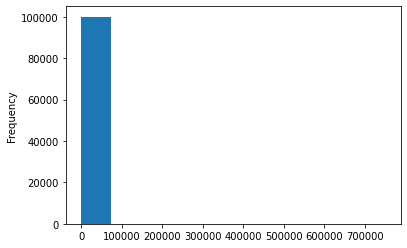

In [65]:
df['traffic_disruption(min)'].plot(kind='hist')

In [66]:
target = 'Severity'

y = df[target]
X = df.drop(target, axis=1)

In [67]:
y.value_counts(normalize=True)

2.0    0.675457
3.0    0.283663
4.0    0.032170
1.0    0.008710
Name: Severity, dtype: float64

In [68]:
#Baseline accuracy
baseline_acc = y.value_counts(normalize=True).max()
print('Baseline accuracy:',baseline_acc)

Baseline accuracy: 0.6754567545675457


In [69]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(df, test_size=.2, random_state=42)
X_train, y_train = train.drop(target, axis=1), train[target]
X_val, y_val = val.drop(target, axis=1), val[target]

In [70]:
print(train.shape, val.shape, df.shape)

(79999, 38) (20000, 38) (99999, 38)


# Logistic Regression

In [71]:
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from xgboost import XGBClassifier

In [72]:
model = make_pipeline(
        OrdinalEncoder(),
        SimpleImputer(strategy='most_frequent'),
        LogisticRegression(n_jobs=-1)
)
model.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Source', 'Side', 'State', 'Timezone',
                                      'Wind_Direction', 'Weather_Condition',
                                      'Sunrise_Sunset', 'Civil_Twilight',
                                      'Nautical_Twilight',
                                      'Astronomical_Twilight', 'Weekday'],
                                mapping=[{'col': 'Source',
                                          'data_type': dtype('O'),
                                          'mapping': Bing             1
MapQuest         2
MapQuest-Bing    3
NaN             -2
dtype: int64},
                                         {'col': 'Side',
                                          'data_type': dtyp...
                                          'data_type': dtype('O'),
                                          'mapping': Day      1
Night    2
NaN      3
dtype: int64},
                                         {'co

In [73]:
print("Training accuracy:", model.score(X_train,y_train))
print("Validation accuracy:", model.score(X_val,y_val))

Training accuracy: 0.6850210627632846
Validation accuracy: 0.68235


Text(0.5, 1.0, 'Confusion Matrix: Logistic regression model')

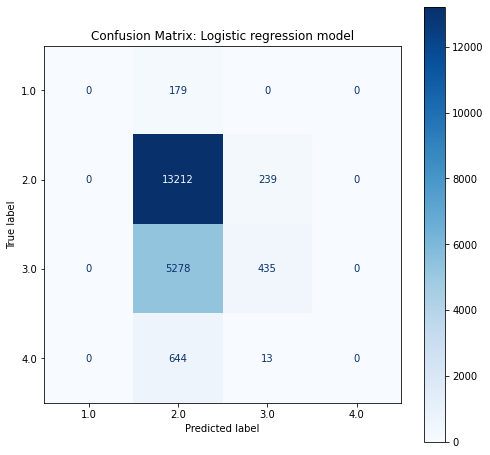

In [74]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(8,8))

plot_confusion_matrix(model, X_val, y_val, cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix: Logistic regression model')

# Decision Tree Model

In [75]:
model_dt = make_pipeline(       
        OrdinalEncoder(),
        SimpleImputer(strategy='median'),
        DecisionTreeClassifier()
)
model_dt.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Source', 'Side', 'State', 'Timezone',
                                      'Wind_Direction', 'Weather_Condition',
                                      'Sunrise_Sunset', 'Civil_Twilight',
                                      'Nautical_Twilight',
                                      'Astronomical_Twilight', 'Weekday'],
                                mapping=[{'col': 'Source',
                                          'data_type': dtype('O'),
                                          'mapping': Bing             1
MapQuest         2
MapQuest-Bing    3
NaN             -2
dtype: int64},
                                         {'col': 'Side',
                                          'data_type': dtyp...
                                          'data_type': dtype('O'),
                                          'mapping': Day      1
Night    2
NaN      3
dtype: int64},
                                         {'co

In [76]:
print("Training accuracy:", model_dt.score(X_train,y_train))
print("Validation accuracy:", model_dt.score(X_val,y_val))

Training accuracy: 1.0
Validation accuracy: 0.72025


Text(0.5, 1.0, 'Confusion Matrix: Logistic regression model')

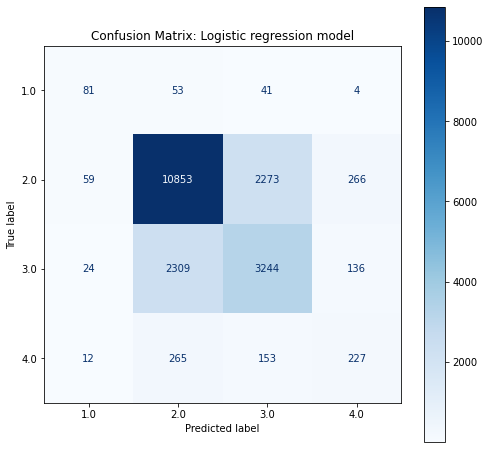

In [77]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

plot_confusion_matrix(model_dt, X_val, y_val, cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix: Logistic regression model')

# Random Forest Model

In [78]:
model_rf = make_pipeline(
        OrdinalEncoder(),
        SimpleImputer(strategy='median'),
        RandomForestClassifier()
)
model_rf.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Source', 'Side', 'State', 'Timezone',
                                      'Wind_Direction', 'Weather_Condition',
                                      'Sunrise_Sunset', 'Civil_Twilight',
                                      'Nautical_Twilight',
                                      'Astronomical_Twilight', 'Weekday'],
                                mapping=[{'col': 'Source',
                                          'data_type': dtype('O'),
                                          'mapping': Bing             1
MapQuest         2
MapQuest-Bing    3
NaN             -2
dtype: int64},
                                         {'col': 'Side',
                                          'data_type': dtyp...
                                          'data_type': dtype('O'),
                                          'mapping': Day      1
Night    2
NaN      3
dtype: int64},
                                         {'co

In [79]:
print("Training accuracy:", model_rf.score(X_train,y_train))
print("Validation accuracy:", model_rf.score(X_val,y_val))

Training accuracy: 1.0
Validation accuracy: 0.78195


Text(0.5, 1.0, 'Confusion Matrix: Logistic regression model')

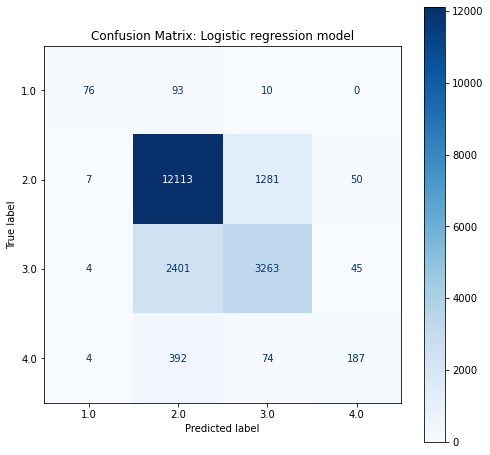

In [80]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

plot_confusion_matrix(model_rf, X_val, y_val, cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix: Logistic regression model')

# XGBClassifier Model

In [81]:
model_xgb = make_pipeline(
        OrdinalEncoder(),
        SimpleImputer(strategy='median'),
        XGBClassifier()
)
model_xgb.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Source', 'Side', 'State', 'Timezone',
                                      'Wind_Direction', 'Weather_Condition',
                                      'Sunrise_Sunset', 'Civil_Twilight',
                                      'Nautical_Twilight',
                                      'Astronomical_Twilight', 'Weekday'],
                                mapping=[{'col': 'Source',
                                          'data_type': dtype('O'),
                                          'mapping': Bing             1
MapQuest         2
MapQuest-Bing    3
NaN             -2
dtype: int64},
                                         {'col': 'Side',
                                          'data_type': dtyp...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                       

In [82]:
print("Training accuracy:", model_xgb.score(X_train,y_train))
print("Validation accuracy:", model_xgb.score(X_val,y_val))

Training accuracy: 0.8560357004462555
Validation accuracy: 0.80345


Text(0.5, 1.0, 'Confusion Matrix: Logistic regression model')

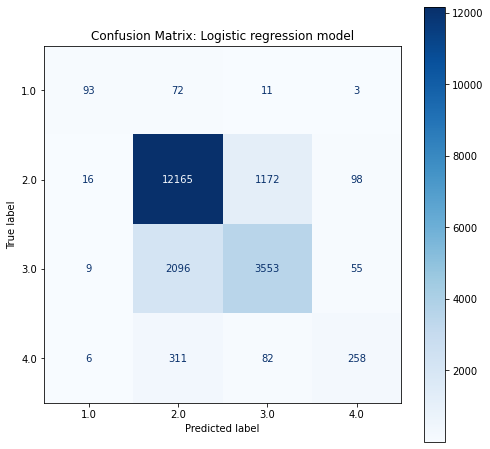

In [83]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

plot_confusion_matrix(model_xgb, X_val, y_val, cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix: Logistic regression model')

# Feature Selection

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99999 entries, 3173614 to 539090
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Source                   99999 non-null  object 
 1   TMC                      70520 non-null  float64
 2   Severity                 99999 non-null  float64
 3   Start_Lat                99999 non-null  float64
 4   Start_Lng                99999 non-null  float64
 5   Distance(mi)             99999 non-null  float64
 6   Side                     99999 non-null  object 
 7   State                    99999 non-null  object 
 8   Timezone                 99886 non-null  object 
 9   Temperature(F)           98115 non-null  float64
 10  Humidity(%)              97990 non-null  float64
 11  Pressure(in)             98385 non-null  float64
 12  Visibility(mi)           97782 non-null  float64
 13  Wind_Direction           98289 non-null  object 
 14  Wind_Speed(mph)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

numeric_features = ['TMC', ]

# Tune Model

In [ ]:
#feature_imp = model.named_steps['logisticregression'].feature_importances_
#features= X_train.columns

In [ ]:
pd.series(feature_imp, features).sort_values(ascending=False).head(5).plot(kind='barh')